## Libraries

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import os
from sklearn.metrics import confusion_matrix




/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Loading the model and data

In [2]:
# --- Define the path RELATIVE to this notebook's location ---
artifacts_path = '../../model_output/recommendation_model/'

# Let's verify this path before trying to load from it
print("--- Verifying Artifact Path ---")
print(f"This notebook's directory is likely: .../ML/analysis/risk_model/")
print(f"Relative path being used: {artifacts_path}")
print(f"The code will look for artifacts at the absolute path: {os.path.abspath(artifacts_path)}")
print(f"Does this path exist? {os.path.exists(os.path.abspath(artifacts_path))}")

# Define the full paths for the files
model_path = os.path.join(artifacts_path, 'recommendation_model.joblib')
test_set_path = os.path.join(artifacts_path, 'test_set_for_diagnostics.csv')

# Load the artifacts
try:
    model = joblib.load(model_path)
    test_df = pd.read_csv(test_set_path)
    print("\n✅ Successfully loaded model and test set.")
    display(test_df.head())
except FileNotFoundError:
    print(f"\n❌ ERROR: Could not find artifacts.")
    print(f"   The notebook looked for them at this location: {os.path.abspath(artifacts_path)}")
    print("   ACTION: Please ensure you have run the '2_Model_Training.ipynb' notebook to save the files.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

--- Verifying Artifact Path ---
This notebook's directory is likely: .../ML/analysis/risk_model/
Relative path being used: ../../model_output/recommendation_model/
The code will look for artifacts at the absolute path: /Users/ulisesgordillo/Downloads/capstone/ML/model_output/recommendation_model
Does this path exist? True

✅ Successfully loaded model and test set.


,SupplierName,GarmentType,Material,Weight,ProposedUnitsPerCarton,ProposedFoldingMethod,ProposedLayout,Size,Collection,ActualQuality
0,SupplierA,T-Shirt,Polyester,0.12,39,Method1,LayoutB,M,Winter,1
1,SupplierG,Shorts,Polyester,0.23,20,Method2,LayoutB,M,Summer,1
2,SupplierH,Shirt,Polyester,0.18,39,Method1,LayoutA,M,Spring,1
3,SupplierE,Dress,Cotton,0.53,17,Method1,LayoutB,XS,Spring,1
4,SupplierA,Shirt,Polyester,0.15,36,Method2,LayoutB,S,Autumn,1


In [3]:
# Ensure test_df is loaded
if 'test_df' not in globals():
    test_df = pd.read_csv(test_set_path)

# Identify categorical columns (object or category dtype)
categorical_cols = test_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Ensure categorical columns are of type 'category'
for col in categorical_cols:
    if col in test_df.columns:
        test_df[col] = test_df[col].astype('category')

# Make predictions if you haven't already
features_for_model = [col for col in test_df.columns if col not in ['ActualQuality']]
predictions = model.predict(test_df[features_for_model])
probabilities = model.predict_proba(test_df[features_for_model])[:, 1]

# Add predictions and probabilities to the DataFrame
test_df['PredictedQuality'] = predictions
test_df['PredictedQualityProba'] = probabilities

# Create a 'PredictionError' column to easily find the biggest mistakes
# This measures how "wrong" the model was. A high error means it was confident but wrong.
test_df['PredictionError'] = (test_df['ActualQuality'] - test_df['PredictedQualityProba']).abs()

# Create a 'ResultType' column for easy filtering
def get_result_type(row):
    if row['ActualQuality'] == 1 and row['PredictedQuality'] == 1:
        return 'True Positive'
    elif row['ActualQuality'] == 0 and row['PredictedQuality'] == 0:
        return 'True Negative'
    elif row['ActualQuality'] == 0 and row['PredictedQuality'] == 1:
        return 'False Positive'
    else: # ActualQuality == 1 and PredictedQuality == 0
        return 'False Negative'

test_df['ResultType'] = test_df.apply(get_result_type, axis=1)

print("Helper columns ('PredictionError', 'ResultType') added.")
display(test_df[['ActualQuality', 'PredictedQuality', 'ResultType', 'PredictionError']].head())


Helper columns ('PredictionError', 'ResultType') added.


,ActualQuality,PredictedQuality,ResultType,PredictionError
0,1,1,True Positive,0.202830
1,1,1,True Positive,0.407917
2,1,0,False Negative,0.695153
3,1,0,False Negative,0.512289
4,1,1,True Positive,0.178831


## Analysis

First we will load the confusion matrix

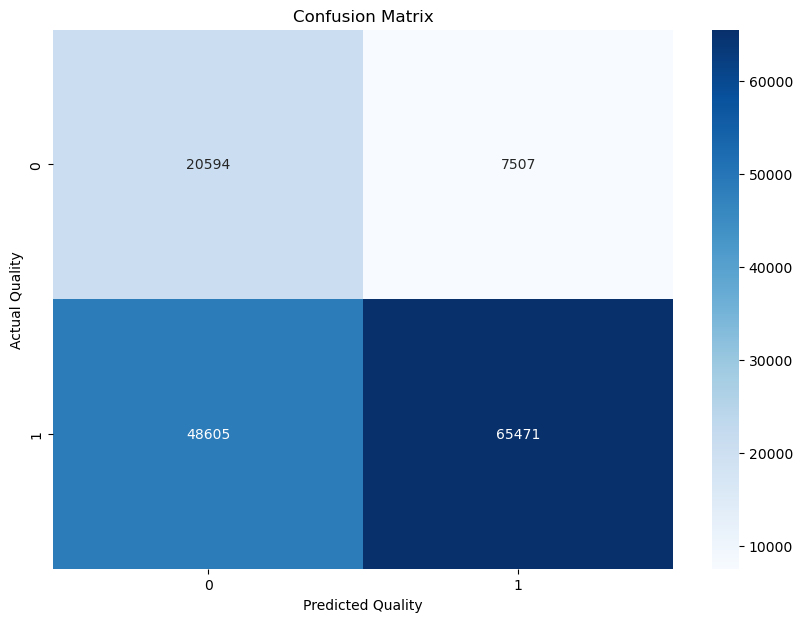

In [4]:
cm = confusion_matrix(test_df['ActualQuality'], predictions)

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=model.classes_, columns=model.classes_)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.show()  

### Tables

In [5]:
#  Analysis 1: The Biggest Mistakes (Highest PredictionError) 

print ("Top 10 Most Confidently Wrong Predictions")
# Sorting by PredictionError shows us where the model's confidence was most misplaced.
display(test_df.sort_values(by='PredictionError', ascending=False).head(10))

Top 10 Most Confidently Wrong Predictions


,SupplierName,GarmentType,Material,Weight,ProposedUnitsPerCarton,ProposedFoldingMethod,ProposedLayout,Size,Collection,ActualQuality,PredictedQuality,PredictedQualityProba,PredictionError,ResultType
84108,SupplierH,Hoodie,Wool,1.07,8,Method3,LayoutD,XS,Winter,1,0,0.153407,0.846593,False Negative
98122,SupplierH,Suit,Wool,1.18,8,Method3,LayoutE,S,Autumn,1,0,0.155951,0.844049,False Negative
31811,SupplierH,Suit,Wool,1.38,8,Method3,LayoutE,L,Spring,1,0,0.157840,0.842160,False Negative
39988,SupplierH,Suit,Wool,1.27,9,Method3,LayoutE,S,Autumn,1,0,0.162340,0.837660,False Negative
94526,SupplierH,Jacket,Wool,1.03,6,Method3,LayoutE,XS,Summer,1,0,0.163560,0.836440,False Negative
14668,SupplierH,Suit,Wool,1.20,9,Method3,LayoutD,L,Spring,1,0,0.164659,0.835341,False Negative
59405,SupplierH,Suit,Wool,1.31,6,Method3,LayoutD,M,Autumn,1,0,0.165252,0.834748,False Negative
42495,SupplierH,Sweater,Wool,1.04,4,Method3,LayoutD,L,Summer,1,0,0.166151,0.833849,False Negative
55644,SupplierA,Shirt,Denim,0.28,23,Method2,LayoutC,M,Summer,0,1,0.833680,0.833680,False Positive
19906,SupplierH,Suit,Wool,1.27,8,Method3,LayoutD,XL,Summer,1,0,0.167471,0.832529,False Negative


In [6]:
# Analysis 2: Deep Dive into False Positives (Missed Risks)

print( "Investigating the Most Dangerous Errors: False Positives")
false_positives_df = test_df[test_df['ResultType'] == 'False Positive']
print(f"Total Missed Risks in test set: {len(false_positives_df)}")

print("\nWhich suppliers are most often involved in these missed risks?")
display(false_positives_df['SupplierName'].value_counts().nlargest(5).to_frame())

print("\nWhich garment types are most often involved?")
display(false_positives_df['GarmentType'].value_counts().nlargest(5).to_frame())

print("\nLet's look at the top 5 missed risks the model was most confident about:")
# Sorting by PredictedQualityProba (descending) shows the ones the model was *surest* were good.
display(false_positives_df.sort_values(by='PredictedQualityProba', ascending=False).head(5))

Investigating the Most Dangerous Errors: False Positives
Total Missed Risks in test set: 7507

Which suppliers are most often involved in these missed risks?


,count
SupplierName,
SupplierA,3122
SupplierB,3038
SupplierG,799
SupplierE,544
SupplierC,4



Which garment types are most often involved?


,count
GarmentType,
Shirt,1527
Pants,1202
Jacket,787
T-Shirt,686
Dress,654



Let's look at the top 5 missed risks the model was most confident about:


,SupplierName,GarmentType,Material,Weight,ProposedUnitsPerCarton,ProposedFoldingMethod,ProposedLayout,Size,Collection,ActualQuality,PredictedQuality,PredictedQualityProba,PredictionError,ResultType
55644,SupplierA,Shirt,Denim,0.28,23,Method2,LayoutC,M,Summer,0,1,0.833680,0.833680,False Positive
31882,SupplierA,Pants,Linen,0.36,21,Method2,LayoutB,M,Summer,0,1,0.830750,0.830750,False Positive
123205,SupplierA,T-Shirt,Linen,0.14,35,Method3,LayoutB,S,Summer,0,1,0.828399,0.828399,False Positive
112243,SupplierA,Shirt,Cotton,0.22,21,Method1,LayoutB,S,Autumn,0,1,0.828270,0.828270,False Positive
142121,SupplierA,Shirt,Denim,0.24,25,Method2,LayoutA,XS,Autumn,0,1,0.825915,0.825915,False Positive


In [7]:
# --- Analysis 3: Deep Dive into False Negatives (Wasted Effort) ---

print("--- Investigating Wasted Effort: False Negatives ---")
false_negatives_df = test_df[test_df['ResultType'] == 'False Negative']
print(f"Total instances of 'Wasted Effort' in test set: {len(false_negatives_df)}")

print("\nWhich suppliers are most often flagged unnecessarily?")
display(false_negatives_df['SupplierName'].value_counts().nlargest(5).to_frame())

print("\nWhich garment types?")
display(false_negatives_df['GarmentType'].value_counts().nlargest(5).to_frame())

print("\nLet's look at the top 5 'safest' packages that were still flagged as risky:")
# Sorting by PredictedQualityProba (ascending) shows the ones the model thought were *most* risky.
display(false_negatives_df.sort_values(by='PredictedQualityProba', ascending=True).head(5))

--- Investigating Wasted Effort: False Negatives ---
Total instances of 'Wasted Effort' in test set: 48605

Which suppliers are most often flagged unnecessarily?


,count
SupplierName,
SupplierC,15609
SupplierD,10306
SupplierF,6322
SupplierE,6040
SupplierB,5723



Which garment types?


,count
GarmentType,
Shirt,9678
Pants,7042
Jacket,4872
T-Shirt,4646
Skirt,3709



Let's look at the top 5 'safest' packages that were still flagged as risky:


,SupplierName,GarmentType,Material,Weight,ProposedUnitsPerCarton,ProposedFoldingMethod,ProposedLayout,Size,Collection,ActualQuality,PredictedQuality,PredictedQualityProba,PredictionError,ResultType
84108,SupplierH,Hoodie,Wool,1.07,8,Method3,LayoutD,XS,Winter,1,0,0.153407,0.846593,False Negative
98122,SupplierH,Suit,Wool,1.18,8,Method3,LayoutE,S,Autumn,1,0,0.155951,0.844049,False Negative
31811,SupplierH,Suit,Wool,1.38,8,Method3,LayoutE,L,Spring,1,0,0.157840,0.842160,False Negative
39988,SupplierH,Suit,Wool,1.27,9,Method3,LayoutE,S,Autumn,1,0,0.162340,0.837660,False Negative
94526,SupplierH,Jacket,Wool,1.03,6,Method3,LayoutE,XS,Summer,1,0,0.163560,0.836440,False Negative


In [8]:
# --- Analysis 4: Drill-Down on High-Error, Heavy Packages ---

print("Investigating the 'Hidden Outliers': Where does the model fail on heavy packages?")

# Define our thresholds for "heavy" and "high error"
# We can adjust these based on the scatter plot
WEIGHT_THRESHOLD = 1.5
ERROR_THRESHOLD = 0.7 # An error of 0.7 means the model was very wrong

# Filter the DataFrame to find only these specific cases
hidden_outliers_df = test_df[
    (test_df['Weight'] > WEIGHT_THRESHOLD) &
    (test_df['PredictionError'] > ERROR_THRESHOLD)
]

print(f"\nFound {len(hidden_outliers_df)} instances of high error on heavy packages.")

if not hidden_outliers_df.empty:
    print("\nWhich suppliers are most common in this high-error group?")
    display(hidden_outliers_df['SupplierName'].value_counts().to_frame())
    
    print("\nWhich garment types?")
    display(hidden_outliers_df['GarmentType'].value_counts().to_frame())
    
    print("\nWhat were the results for these specific outliers?")
    display(hidden_outliers_df['ResultType'].value_counts().to_frame())
    
    print("\nShowing a sample of these 'hidden outlier' packages:")
    display(hidden_outliers_df.head(10))
else:
    print("No packages met the criteria for this specific outlier analysis.")

Investigating the 'Hidden Outliers': Where does the model fail on heavy packages?

Found 348 instances of high error on heavy packages.

Which suppliers are most common in this high-error group?


,count
SupplierName,
SupplierD,109
SupplierF,109
SupplierC,71
SupplierH,42
SupplierE,12
SupplierG,5
SupplierA,0
SupplierB,0



Which garment types?


,count
GarmentType,
Coat,345
Suit,3
Blouse,0
Dress,0
Hoodie,0
Jacket,0
Pants,0
Shirt,0
Shorts,0



What were the results for these specific outliers?


,count
ResultType,
False Negative,348



Showing a sample of these 'hidden outlier' packages:


,SupplierName,GarmentType,Material,Weight,ProposedUnitsPerCarton,ProposedFoldingMethod,ProposedLayout,Size,Collection,ActualQuality,PredictedQuality,PredictedQualityProba,PredictionError,ResultType
44,SupplierC,Coat,Wool,1.56,8,Method3,LayoutD,M,Autumn,1,0,0.276837,0.723163,False Negative
1167,SupplierE,Coat,Wool,2.04,6,Method3,LayoutD,S,Spring,1,0,0.294665,0.705335,False Negative
1351,SupplierD,Coat,Linen,1.52,4,Method3,LayoutD,S,Summer,1,0,0.296388,0.703612,False Negative
1742,SupplierD,Coat,Linen,1.51,6,Method2,LayoutE,S,Summer,1,0,0.298046,0.701954,False Negative
2239,SupplierF,Coat,Linen,1.51,8,Method3,LayoutD,M,Autumn,1,0,0.262060,0.737940,False Negative
2307,SupplierE,Coat,Wool,1.67,8,Method3,LayoutE,M,Spring,1,0,0.289154,0.710846,False Negative
2637,SupplierC,Coat,Wool,1.65,5,Method3,LayoutE,L,Winter,1,0,0.251008,0.748992,False Negative
2731,SupplierD,Coat,Cotton,1.54,7,Method1,LayoutE,M,Spring,1,0,0.290440,0.709560,False Negative
2883,SupplierF,Coat,Wool,1.80,6,Method3,LayoutD,XL,Summer,1,0,0.210081,0.789919,False Negative
4480,SupplierD,Coat,Denim,2.08,5,Method2,LayoutE,L,Summer,1,0,0.298767,0.701233,False Negative


In [9]:
# Analysis 5: What's different about the heavy coats the model gets wrong? ---

print("Comparing Features of Correct vs. Incorrect Predictions on Heavy Coats")

# Isolate all heavy coats from the test set
heavy_coats_df = test_df[
    (test_df['GarmentType'] == 'Coat') &
    (test_df['Weight'] > 1.5)
].copy()

# We already created the 'PredictionResult' column (True for correct, False for incorrect)
if 'PredictionResult' not in heavy_coats_df.columns:
     heavy_coats_df['PredictionResult'] = (heavy_coats_df['ActualQuality'] == heavy_coats_df['PredictedQuality'])

# Now, let's group by correctness and look at the average of other features
feature_comparison = heavy_coats_df.groupby('PredictionResult')[
    ['Weight', 'ProposedUnitsPerCarton', 'PredictedQualityProba']
].mean()

print("\nAverage Feature Values for Correct vs. Incorrect Predictions on Heavy Coats")
display(feature_comparison)

# Let's also look at the distribution of the folding methods for these cases
print("\nFolding Method Distribution for Correct vs. Incorrect Predictions on Heavy Coats")
display(pd.crosstab(heavy_coats_df['ProposedFoldingMethod'], heavy_coats_df['PredictionResult']))

Comparing Features of Correct vs. Incorrect Predictions on Heavy Coats

Average Feature Values for Correct vs. Incorrect Predictions on Heavy Coats


,Weight,ProposedUnitsPerCarton,PredictedQualityProba
PredictionResult,,,
False,1.731857,6.575246,0.380910
True,1.726424,6.536388,0.456389



Folding Method Distribution for Correct vs. Incorrect Predictions on Heavy Coats


PredictionResult,False,True
ProposedFoldingMethod,,
Method1,353,290
Method2,609,594
Method3,460,229


### Visualizations

--- Investigating which features are associated with incorrect predictions ---


/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


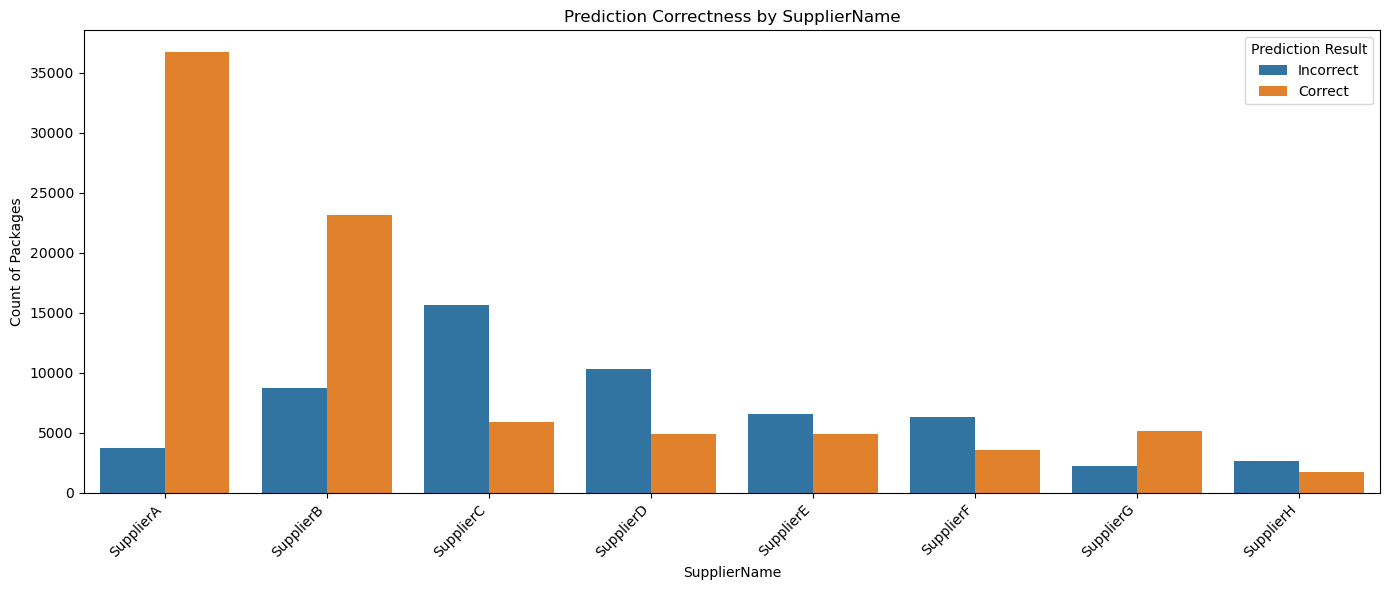

/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


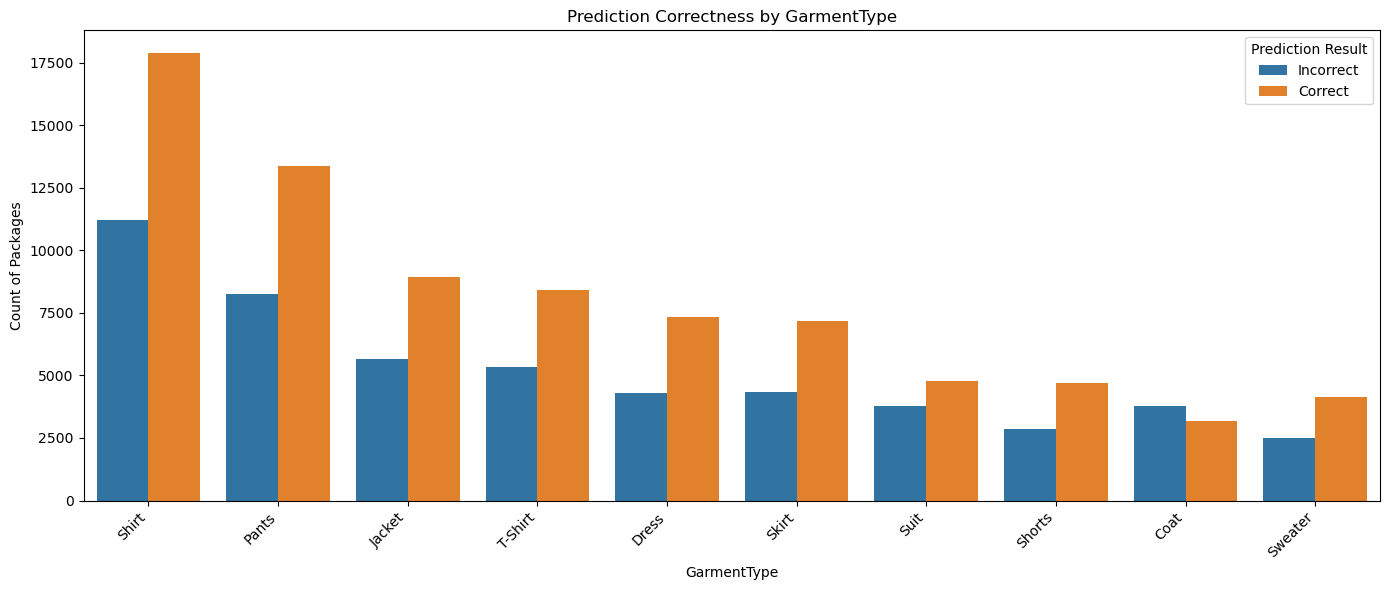

/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


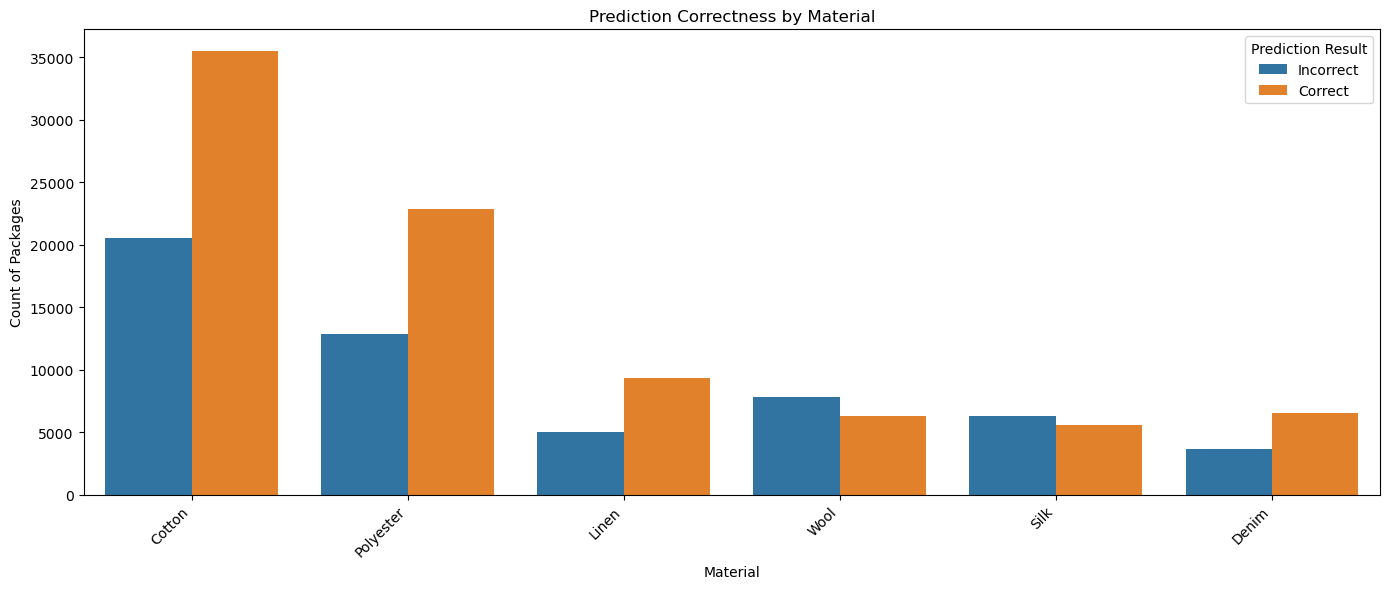

In [10]:
# --- Analysis 4: Visualizing Feature Distributions for Model Errors ---
import seaborn as sns
import matplotlib.pyplot as plt

def plot_error_distribution_by_feature(df, feature_col):
    """Compares the distribution of a feature for correct vs. incorrect predictions."""
    
    # Create a simple 'Correct' vs 'Incorrect' column
    df['PredictionResult'] = (df['ActualQuality'] == df['PredictedQuality'])
    
    plt.figure(figsize=(14, 6))
    sns.countplot(data=df, x=feature_col, hue='PredictionResult', order=df[feature_col].value_counts().index[:10])
    
    plt.title(f'Prediction Correctness by {feature_col}')
    plt.xlabel(feature_col)
    plt.ylabel('Count of Packages')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Prediction Result', labels=['Incorrect', 'Correct'])
    plt.tight_layout()
    plt.show()

# --- Let's use the function to analyze our key features ---
print("--- Investigating which features are associated with incorrect predictions ---")
plot_error_distribution_by_feature(test_df, 'SupplierName')
plot_error_distribution_by_feature(test_df, 'GarmentType')
plot_error_distribution_by_feature(test_df, 'Material')

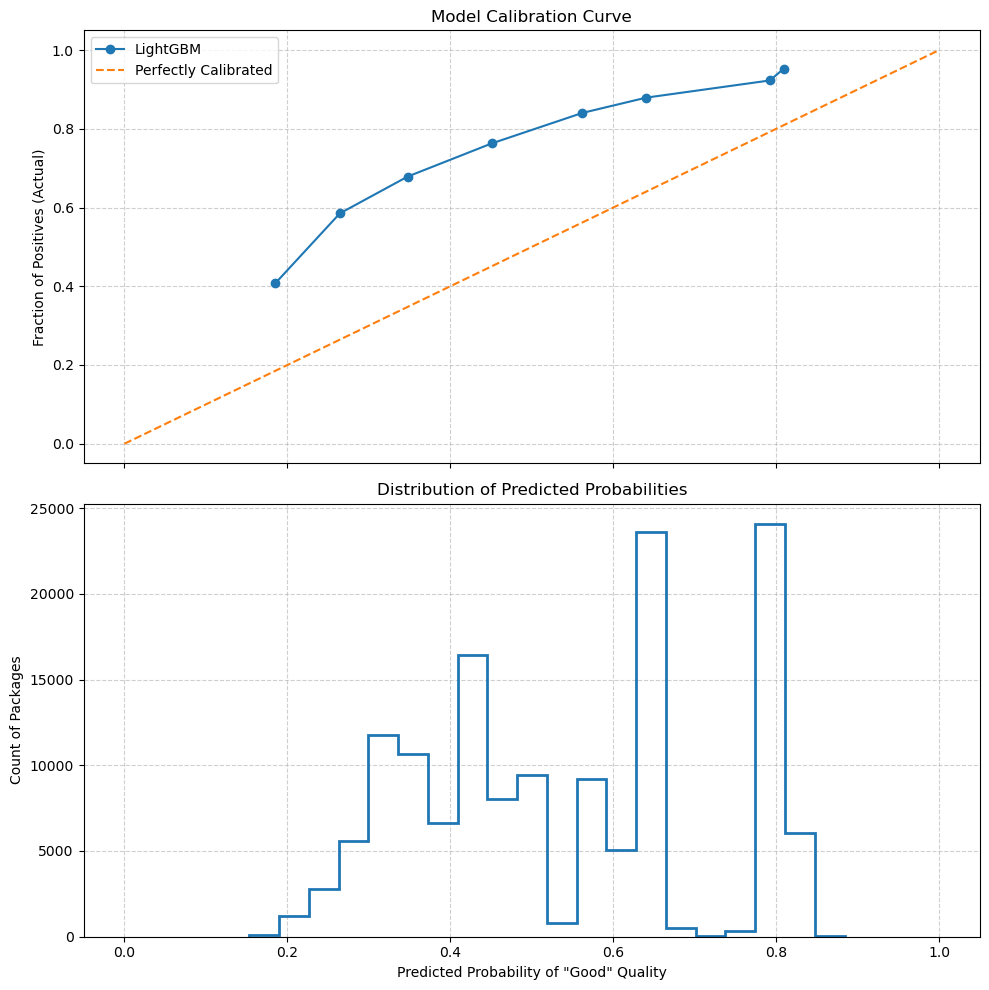

In [11]:
# --- Analysis 5: Model Calibration and Probability Distribution ---
from sklearn.calibration import calibration_curve

# Create the calibration curve
prob_true, prob_pred = calibration_curve(test_df['ActualQuality'], test_df['PredictedQualityProba'], n_bins=10, strategy='uniform')

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# Plot 1: Calibration Curve
ax1.plot(prob_pred, prob_true, marker='o', label='LightGBM')
ax1.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
ax1.set_ylabel('Fraction of Positives (Actual)')
ax1.set_title('Model Calibration Curve')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# Plot 2: Histogram of Predicted Probabilities
ax2.hist(test_df['PredictedQualityProba'], bins=20, histtype='step', lw=2)
ax2.set_xlabel('Predicted Probability of "Good" Quality')
ax2.set_ylabel('Count of Packages')
ax2.set_title('Distribution of Predicted Probabilities')
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

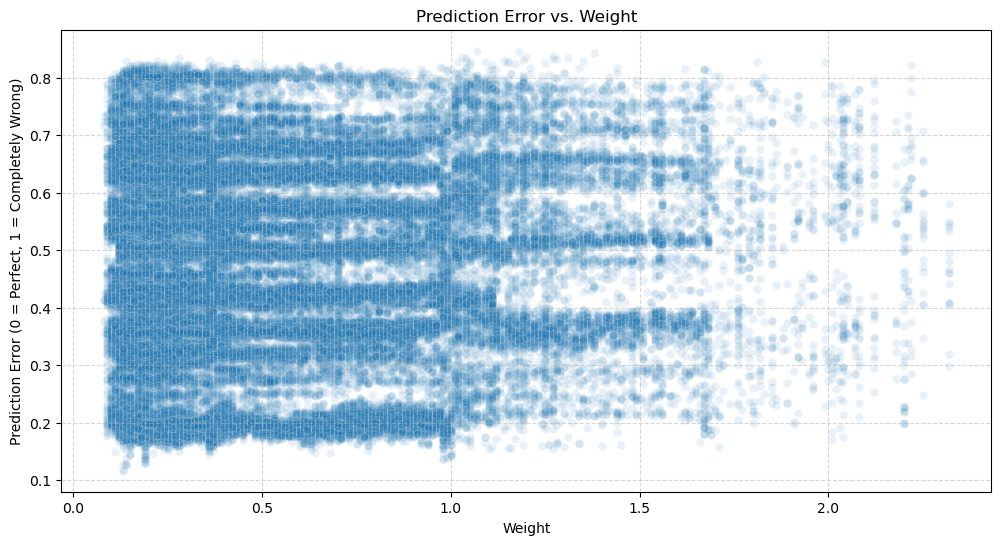

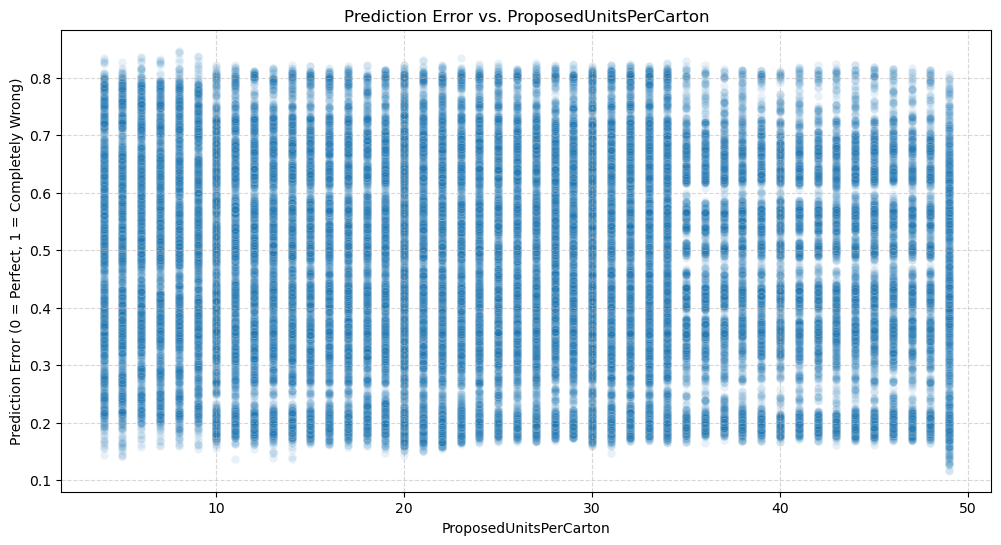

In [12]:
# --- Analysis 6: Visualizing Prediction Error vs. Key Numerical Features ---

# Let's check the top numerical features from your training notebook: 'Weight' and 'ProposedUnitsPerCarton'
key_numerical_features = ['Weight', 'ProposedUnitsPerCarton']

for feature in key_numerical_features:
    plt.figure(figsize=(12, 6))
    # We use a scatter plot with transparency (alpha) to see density
    sns.scatterplot(data=test_df, x=feature, y='PredictionError', alpha=0.1)
    plt.title(f'Prediction Error vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel('Prediction Error (0 = Perfect, 1 = Completely Wrong)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()